In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt
import implicit
import evaluation_measures as ev

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
alpha = 30
train_ui*=alpha
train_iu=train_ui.transpose().tocsr()

In [3]:
model = implicit.als.AlternatingLeastSquares(factors=200, regularization=0.1, iterations=10)
model.fit(train_iu)

In [4]:
def top_k_recommendations(model, user_code_id, item_code_id, topK=10):
    recommendations=[]
    for u in range(train_ui.shape[0]):
        u_recommended_items=model.recommend(u, train_ui, N=10, filter_already_liked_items=True)
        recommendations.append([user_code_id[u]]+list(chain(*u_recommended_items)))
    reco=pd.DataFrame(recommendations)
    reco.iloc[:,1::2]=reco.iloc[:,1::2].applymap(lambda x: item_code_id[x])
    return reco

def estimate(model, user_code_id, item_code_id, test_ui):
    result=[]
    for user, item in zip(*test_ui.nonzero()):
        result.append([user_code_id[user], item_code_id[item], 
            model.rank_items(userid=user, user_items=train_ui, selected_items=[item])[0][1]])
    return result

In [5]:
reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
reco.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', index=False, header=False)

estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', index=False, header=False)

In [6]:
import evaluation_measures as ev
import imp
imp.reload(ev)

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])
#also you can just type ev.evaluate_all(estimations_df, reco) - I put above values as default

943it [00:00, 10362.14it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.266922  3.066824    0.25175  0.182636  0.173211  0.197806   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.160086      0.201137  0.299236  0.167611  0.513715  0.588679   

         HR  Reco in test  Test coverage  Shannon     Gini  
0  0.878049      0.999894       0.504329  5.74491  0.82298

### Hyperparameters tuning

### Number of latent factors

In [7]:
from tqdm import tqdm
result=[]
for factors in tqdm([i for i in np.arange(25,400,25)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=100
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Factors", factors)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/15 [00:00<?, ?it/s]
943it [00:00, 11340.25it/s]
  7%|▋         | 1/15 [00:01<00:14,  1.04s/it]
943it [00:00, 10730.67it/s]
 13%|█▎        | 2/15 [00:02<00:13,  1.05s/it]
943it [00:00, 10477.79it/s]
 20%|██        | 3/15 [00:03<00:12,  1.05s/it]
943it [00:00, 10807.02it/s]
 27%|██▋       | 4/15 [00:04<00:11,  1.06s/it]
943it [00:00, 10688.45it/s]
 33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]
943it [00:00, 10635.28it/s]
 40%|████      | 6/15 [00:06<00:10,  1.16s/it]
943it [00:00, 10505.79it/s]
 47%|████▋     | 7/15 [00:08<00:09,  1.21s/it]
943it [00:00, 10545.25it/s]
 53%|█████▎    | 8/15 [00:09<00:08,  1.25s/it]
943it [00:00, 9917.03it/s]
 60%|██████    | 9/15 [00:11<00:08,  1.37s/it]
943it [00:00, 10496.31it/s]
 67%|██████▋   | 10/15 [00:12<00:07,  1.45s/it]
943it [00:00, 10709.20it/s]
 73%|███████▎  | 11/15 [00:14<00:06,  1.52s/it]
943it [00:00, 9853.29it/s]
 80%|████████  | 12/15 [00:15<00:04,  1.54s/it]
943it [00:00, 10531.27it/s]
 87%|████████▋ | 13/15 [00:17<00

Factors      RMSE       MAE  precision    recall       F_1      F_05  \
0       25  2.845245  2.619957   0.105514  0.110613  0.092224  0.094515   
0       50  2.898919  2.677354   0.140933  0.137985  0.117747  0.123156   
0       75  2.943577  2.724779   0.171792  0.152722  0.135926  0.146013   
0      100  2.983831  2.766847   0.189926  0.165349  0.146647  0.158954   
0      125  3.014973  2.800528   0.199576  0.161300  0.148262  0.163874   
0      150  3.041675  2.829052   0.212619  0.164436  0.153355  0.171659   
0      175  3.067174  2.855569   0.214846  0.166922  0.154441  0.172930   
0      200  3.084254  2.874435   0.219512  0.166470  0.154820  0.174500   
0      225  3.098310  2.888885   0.221527  0.162908  0.153271  0.174652   
0      250  3.109233  2.900359   0.230011  0.170018  0.160018  0.181677   
0      275  3.123987  2.915849   0.223118  0.163987  0.155116  0.176334   
0      300  3.134676  2.927118   0.233510  0.171744  0.160625  0.183479   
0      325  3.142248  2.935562   0.235949  0.165707  0.160148  0.184367   
0      350  3.150288  2.944923   0.241676  0.173680  0.165615  0.189653   
0      375  3.155423  2.949564   0.242418  0.169734  0.164664  0.189489   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.062768      0.123849  0.121996  0.053640  0.219607  0.552021   
0         0.082511      0.145669  0.162052  0.073554  0.285402  0.565861   
0         0.104399      0.166191  0.199634  0.096243  0.354423  0.573366   
0         0.119313      0.182702  0.218971  0.107420  0.376826  0.579747   
0         0.128433      0.178498  0.232551  0.116528  0.413058  0.577770   
0         0.134979      0.185299  0.245491  0.124203  0.427261  0.579394   
0         0.139700      0.190809  0.248702  0.126277  0.436082  0.580625   
0         0.140021      0.186647  0.256716  0.135486  0.449810  0.580443   
0         0.143348      0.184742  0.254314  0.132189  0.436970  0.578659   
0         0.147210      0.187002  0.271292  0.145652  0.476179  0.582272   
0         0.141845      0.181169  0.259294  0.137734  0.445071  0.579225   
0         0.152039      0.192844  0.269165  0.143070  0.460571  0.583120   
0         0.154185      0.186690  0.274583  0.151069  0.465910  0.580147   
0         0.159549      0.191868  0.283226  0.154631  0.489850  0.584151   
0         0.163519      0.201145  0.275921  0.150416  0.459599  0.582149   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.621421      0.997455       0.727994  6.472770  0.642577  
0  0.745493      0.999576       0.647186  6.259111  0.704468  
0  0.798515      0.999788       0.607504  6.083777  0.751040  
0  0.828208      0.999894       0.565657  5.898606  0.790453  
0  0.854719      0.999894       0.518759  5.803240  0.814069  
0  0.853659      0.999894       0.502165  5.744393  0.824284  
0  0.864263      0.999894       0.492063  5.635818  0.839712  
0  0.862142      0.999788       0.491342  5.626358  0.843260  
0  0.851538      1.000000       0.484848  5.660195  0.839240  
0  0.861082      1.000000       0.471861  5.598262  0.847443  
0  0.851538      1.000000       0.479076  5.552331  0.852713  
0  0.879109      0.999894       0.466811  5.571515  0.849595  
0  0.841994      1.000000       0.463203  5.546160  0.853593  
0  0.868505      1.000000       0.449495  5.486488  0.861326  
0  0.847296      1.000000       0.443001  5.521482  0.858563

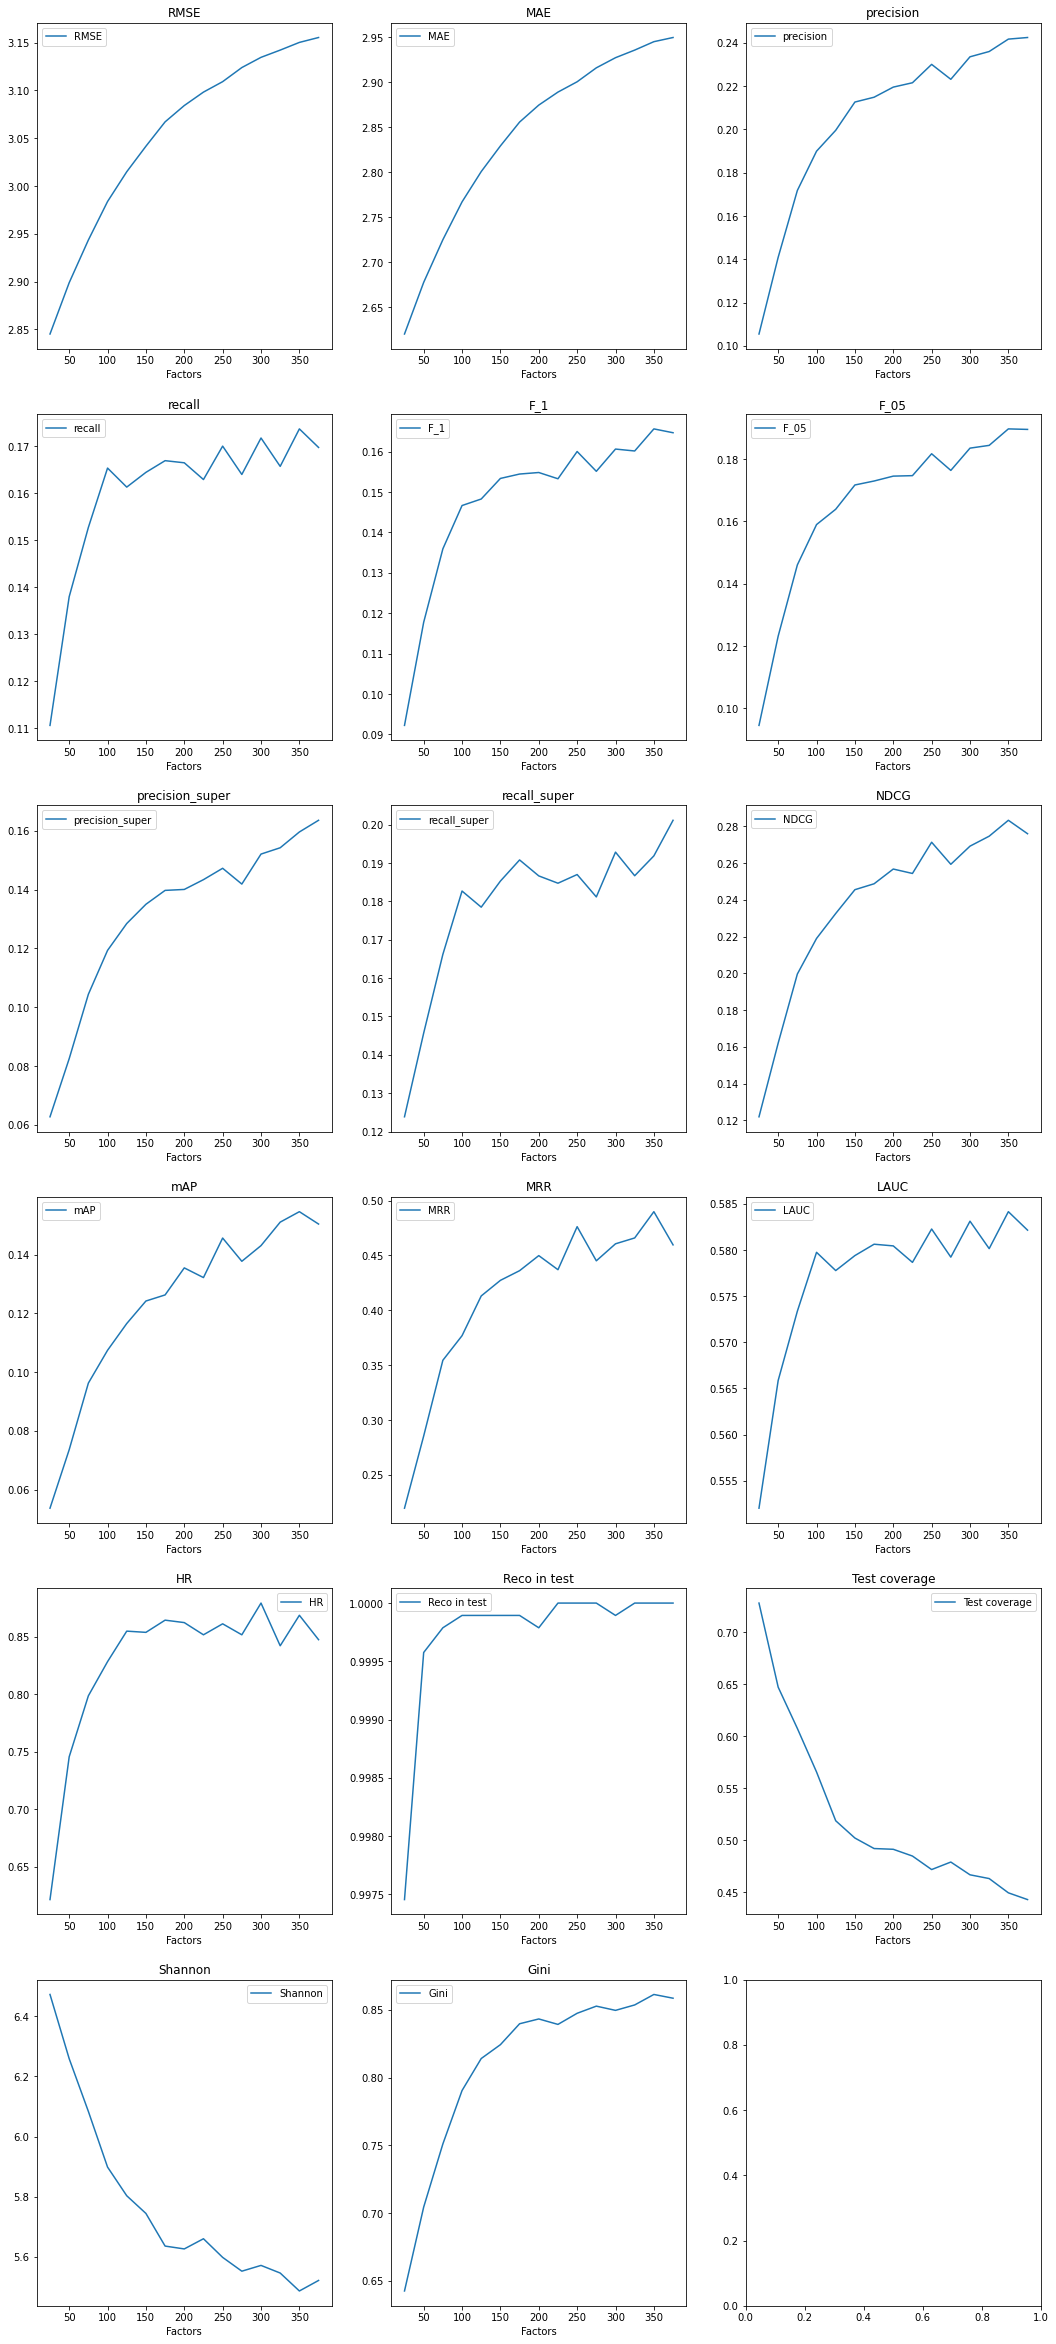

In [8]:
metrics=list(result.columns[[i not in ['Factors'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Factors', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

### Alpha

In [9]:
from tqdm import tqdm
result=[]
for alpha in tqdm([1, 3, 7]+[i for i in np.arange(10,200,20)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=alpha
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/13 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 8224.09it/s]
  8%|▊         | 1/13 [00:02<00:31,  2.65s/it]
0it [00:00, ?it/s]
943it [00:00, 8183.27it/s]
 15%|█▌        | 2/13 [00:05<00:29,  2.69s/it]
0it [00:00, ?it/s]
943it [00:00, 8725.68it/s]
 23%|██▎       | 3/13 [00:08<00:27,  2.76s/it]
0it [00:00, ?it/s]
943it [00:00, 7268.33it/s]
 31%|███       | 4/13 [00:11<00:25,  2.80s/it]
943it [00:00, 10261.14it/s]
 38%|███▊      | 5/13 [00:13<00:20,  2.62s/it]
943it [00:00, 9896.61it/s]
 46%|████▌     | 6/13 [00:15<00:17,  2.49s/it]
943it [00:00, 10718.46it/s]
 54%|█████▍    | 7/13 [00:17<00:14,  2.42s/it]
943it [00:00, 10274.26it/s]
 62%|██████▏   | 8/13 [00:19<00:11,  2.29s/it]
943it [00:00, 9995.22it/s]
 69%|██████▉   | 9/13 [00:21<00:08,  2.22s/it]
943it [00:00, 9917.87it/s]
 77%|███████▋  | 10/13 [00:23<00:06,  2.16s/it]
0it [00:00, ?it/s]
943it [00:00, 8459.01it/s]
 85%|████████▍ | 11/13 [00:26<00:04,  2.18s/it]
943it [00:00, 9801.50it/s]
 92%|█████████▏| 12/

Alpha      RMSE       MAE  precision    recall       F_1      F_05  \
0      1  3.667148  3.489102   0.097137  0.074715  0.068521  0.077218   
0      3  3.626815  3.447637   0.146023  0.103810  0.098579  0.113005   
0      7  3.554143  3.373172   0.221633  0.147120  0.144749  0.169109   
0     10  3.508457  3.325837   0.251007  0.166736  0.164552  0.192116   
0     30  3.353356  3.161808   0.278685  0.193472  0.186691  0.215998   
0     50  3.275296  3.077720   0.257688  0.182688  0.174922  0.200926   
0     70  3.218980  3.017945   0.256734  0.186377  0.175456  0.200517   
0     90  3.176763  2.973046   0.244539  0.172512  0.166475  0.191058   
0    110  3.143349  2.936711   0.238070  0.171926  0.162405  0.186262   
0    130  3.110754  2.901935   0.234995  0.167103  0.160274  0.183921   
0    150  3.092232  2.881814   0.220573  0.156457  0.150352  0.172703   
0    170  3.070960  2.858602   0.215164  0.152678  0.145957  0.167671   
0    190  3.055291  2.841800   0.203818  0.145412  0.139214  0.159774   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.054185      0.072066  0.118156  0.052060  0.265020  0.534088   
0         0.086588      0.104527  0.177685  0.087408  0.359707  0.548837   
0         0.145172      0.166481  0.267707  0.148986  0.493567  0.570812   
0         0.165343      0.194423  0.303119  0.175620  0.534907  0.580745   
0         0.185944      0.222512  0.329472  0.193259  0.549576  0.594207   
0         0.168991      0.210621  0.305865  0.174495  0.517754  0.588738   
0         0.167382      0.210579  0.305096  0.172828  0.520099  0.590554   
0         0.159871      0.192965  0.287939  0.160423  0.493221  0.583590   
0         0.153541      0.187256  0.279234  0.151951  0.487754  0.583242   
0         0.150536      0.186330  0.272901  0.146686  0.472357  0.580823   
0         0.144421      0.184490  0.252383  0.133966  0.434369  0.575430   
0         0.135086      0.162270  0.251273  0.132605  0.444772  0.573533   
0         0.131760      0.164304  0.232864  0.118939  0.411554  0.569834   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.591729      0.993107       0.735931  6.695607  0.541029  
0  0.705196      0.994592       0.711400  6.648019  0.563589  
0  0.827147      0.996819       0.634921  6.311365  0.695948  
0  0.851538      0.998197       0.593074  6.096903  0.751151  
0  0.878049      0.999894       0.476912  5.592693  0.842470  
0  0.874867      0.999894       0.467532  5.519136  0.854988  
0  0.889714      0.999894       0.456710  5.470766  0.859839  
0  0.866384      1.000000       0.448773  5.443263  0.865034  
0  0.860021      0.999788       0.465368  5.469029  0.862758  
0  0.853659      1.000000       0.457431  5.467972  0.863449  
0  0.835631      1.000000       0.456710  5.478962  0.861605  
0  0.829268      1.000000       0.455267  5.480218  0.863607  
0  0.814422      0.999894       0.475469  5.516410  0.856805

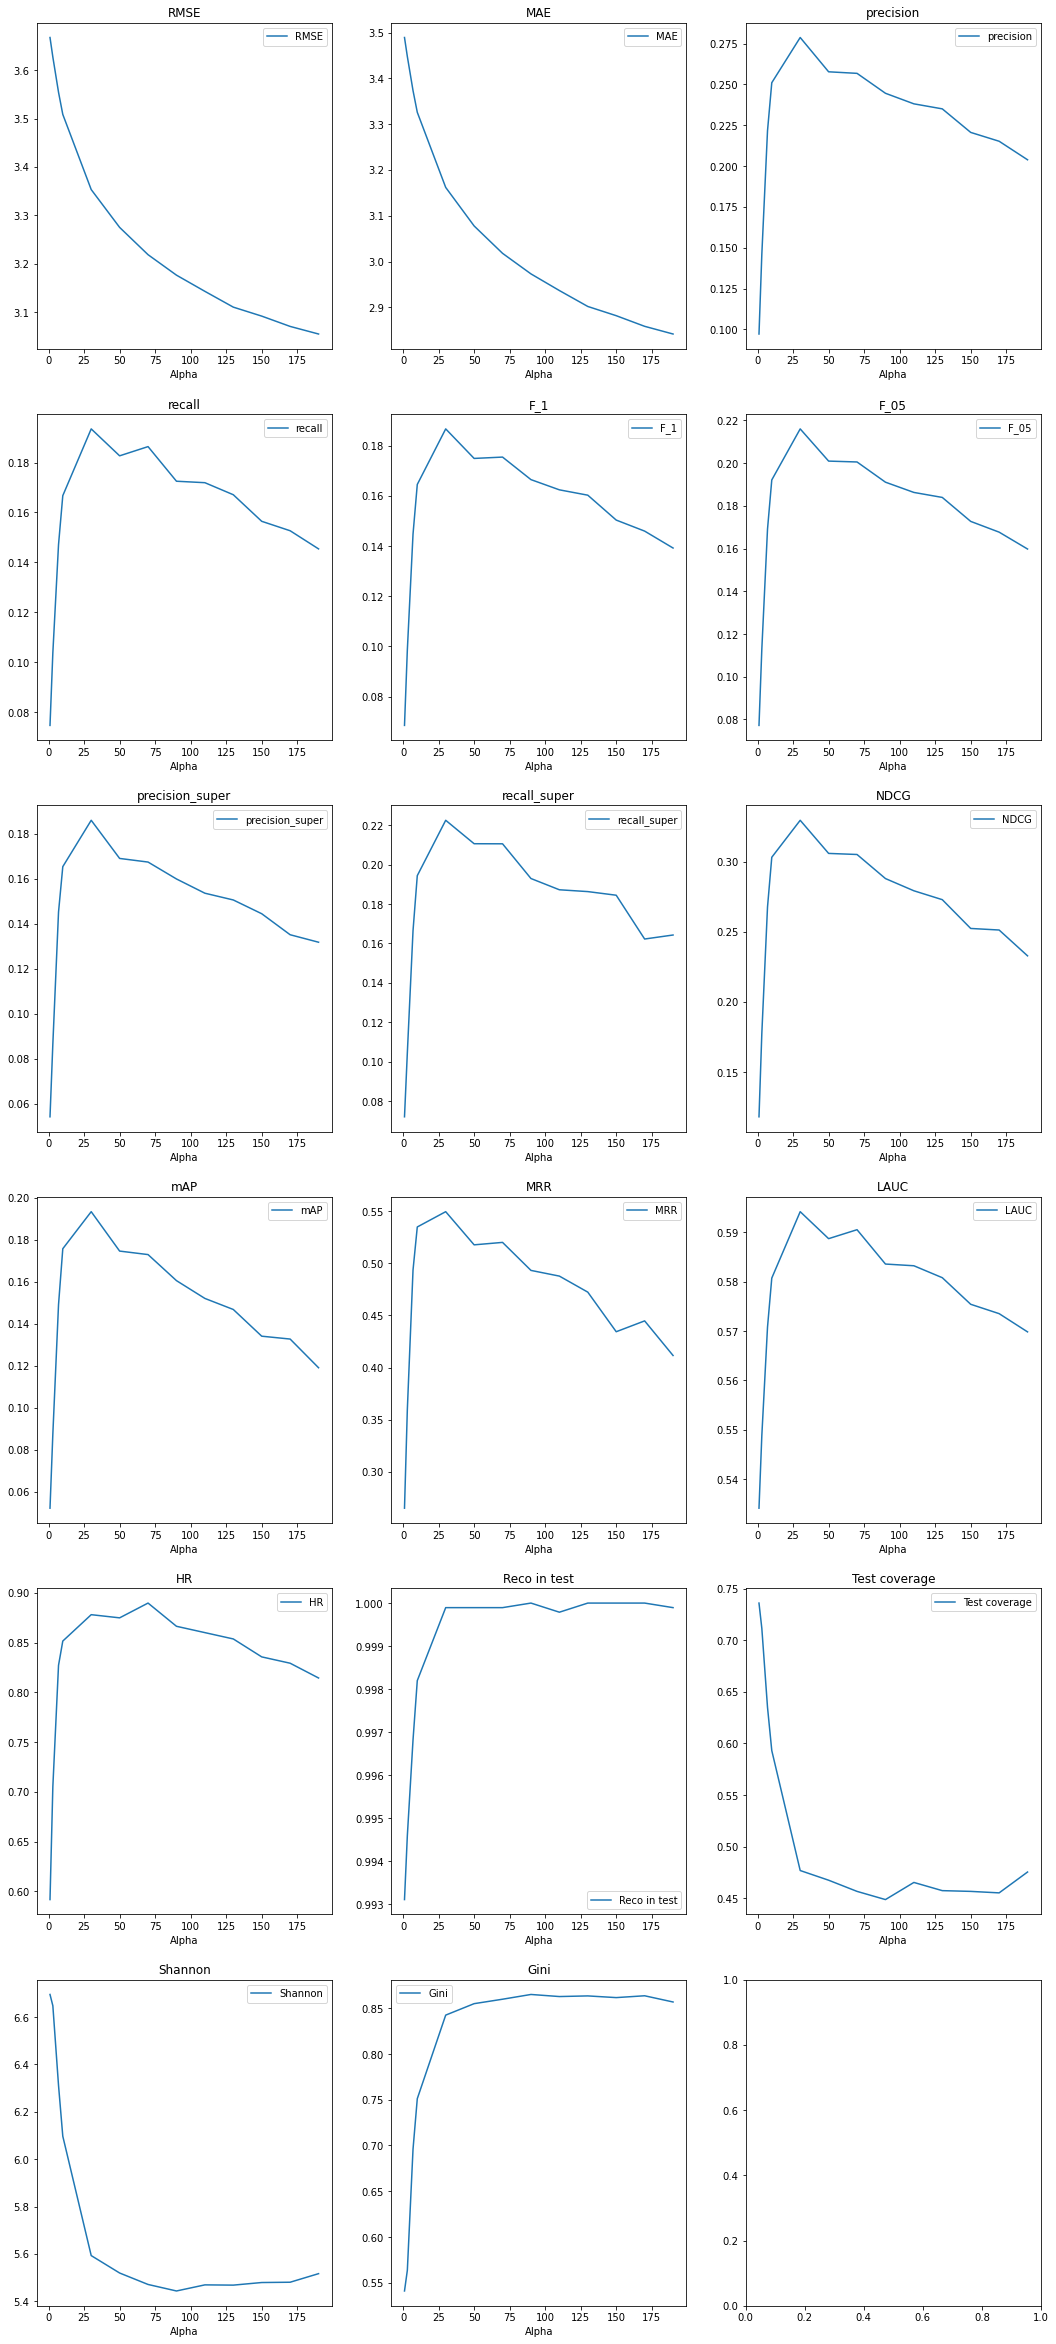

In [10]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

In [11]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 10250.34it/s]
943it [00:00, 10771.14it/s]
943it [00:00, 9255.61it/s]
943it [00:00, 10086.42it/s]
943it [00:00, 12019.93it/s]
943it [00:00, 11892.13it/s]
943it [00:00, 11185.60it/s]
943it [00:00, 11252.04it/s]
943it [00:00, 11415.63it/s]
943it [00:00, 10757.58it/s]
943it [00:00, 10367.98it/s]
943it [00:00, 10480.68it/s]
943it [00:00, 11926.02it/s]
943it [00:00, 9976.49it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0              Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0    Ready_ImplicitALS  3.266922  3.066824   0.251750  0.182636  0.173211   
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.950347  0.749312   0.100636  0.050514  0.055794   
0             Self_SVD  0.914143  0.717131   0.101803  0.042134  0.051610   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0      Ready_SVDBiased  0.939472  0.739816   0.085896  0.036073  0.043528   
0         Ready_Random  1.521845  1.225949   0.047190  0.020753  0.024810   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0        Self_TopRated  1.030712  0.820904   0.000954  0.000188  0.000298   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.197806         0.160086      0.201137  0.299236  0.167611  0.513715   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.070753         0.091202      0.082734  0.114054  0.053200  0.248803   
0  0.068543         0.091953      0.071255  0.104015  0.048817  0.193027   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.057643         0.077039      0.057463  0.097753  0.045546  0.219839   
0  0.032269         0.029506      0.023707  0.050075  0.018728  0.121957   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.593544  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.588679  0.878049      0.999894       0.504329  5.744910  0.822980  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.521983  0.517497      0.992153       0.210678  4.418683  0.952848  
0  0.517784  0.471898      0.867232       0.147908  3.871296  0.971820  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.514709  0.431601      0.997455       0.168831  4.217578  0.962577  
0  0.506893  0.329799      0.986532       0.184704  5.099706  0.907217  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327

# project task 7: Check how number of iterations of WRMF model influence the evaluation metrics

In [12]:
# we already checked how parameters alpha and factors influence the model performance
# your task is to do a similar thing with param iterations

# expected output is a table reporting the evaluation metrics